In [21]:
# Open data_new_fatalities_smoothed_per_million.csv
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data_new_fatalities_smoothed_per_million.csv')

# Here, take a country iso code for an example country. '-99' is for Kosovo. In the paper Kuwait is chosen as a step-by-step example of our approach.
example_country_iso_code = 'KWT'
example_country_full_name = data[data['iso_code'] == example_country_iso_code]['location'].values[0]
example_country_fatalities_data = data[data['iso_code'] == example_country_iso_code]

# Use the already defined 'dates' variable
dates = data.columns[4:]  # assuming the first 4 columns are iso_code, location, etc.
example_country_fatalities_data = example_country_fatalities_data.loc[example_country_fatalities_data.index[0], dates].values
# take the rolling mean with a window of 7 days to smooth the data
example_country_fatalities_data = pd.Series(example_country_fatalities_data).rolling(window=7, min_periods=1).mean().values


R² values for N=2 to N=11:
N=2: R²=0.492
N=3: R²=0.731
N=4: R²=0.756
N=5: R²=0.888
N=6: R²=0.812
N=7: R²=0.967
N=8: R²=0.969
N=9: R²=0.969
N=10: R²=0.977
N=11: R²=0.976


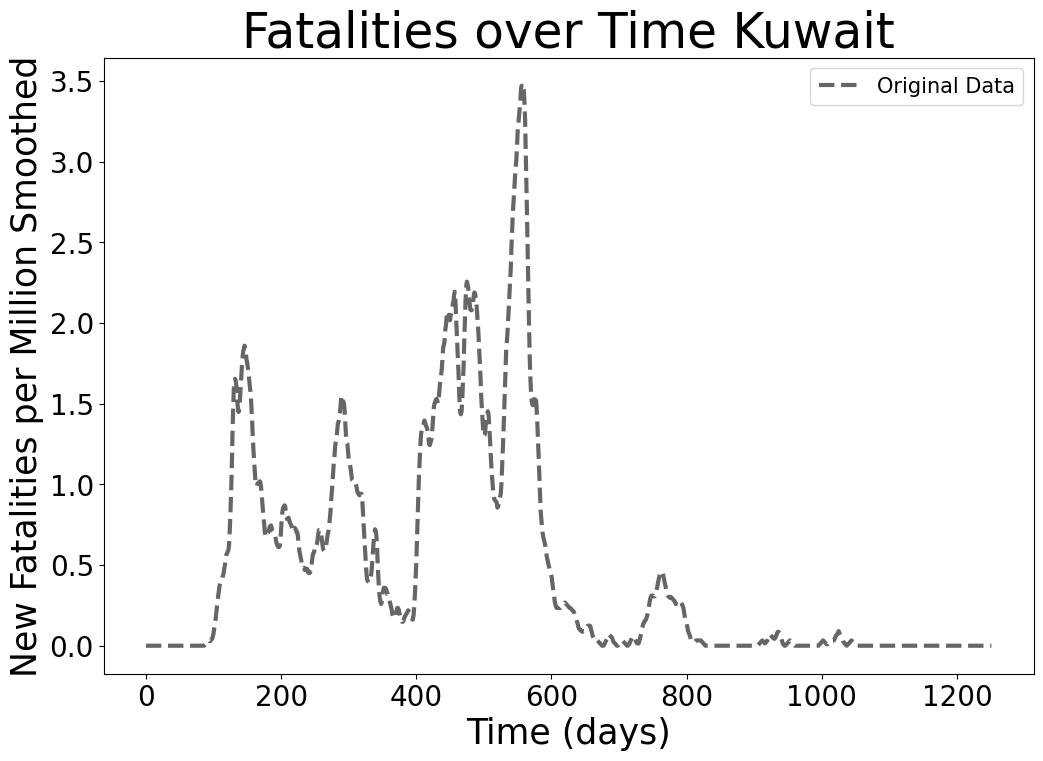

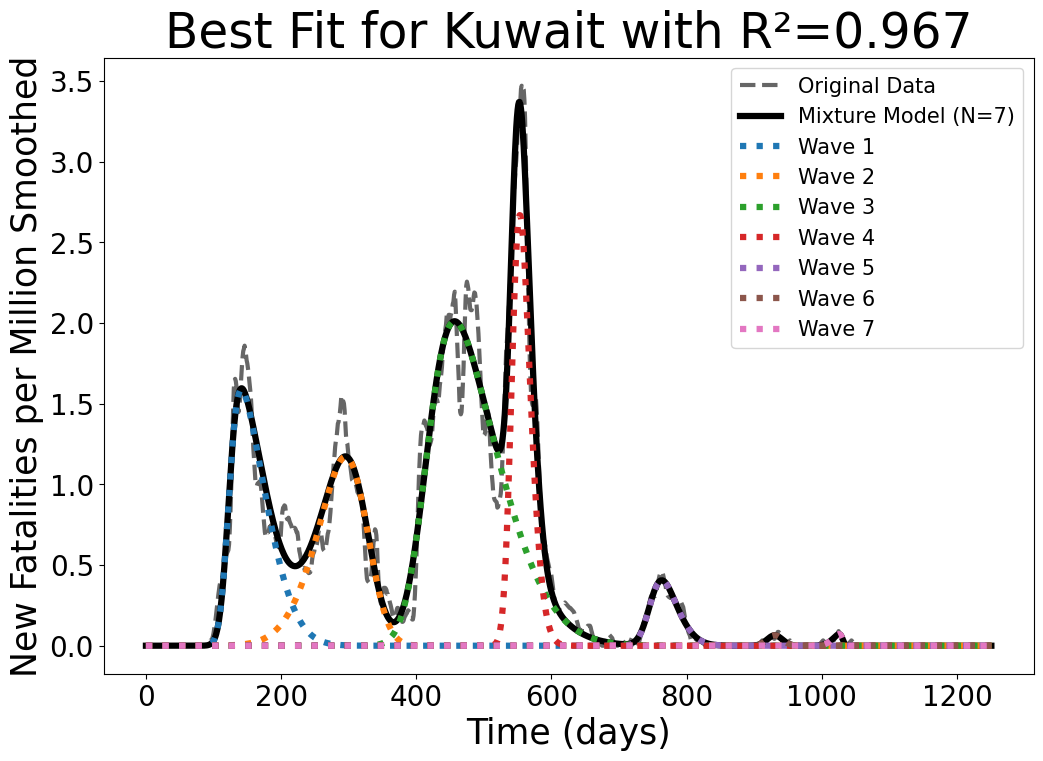

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, optimize as opt
import pandas as pd

# Define the SkewGaussianMixture class
class SkewGaussianMixture:
    def __init__(self, n):
        self.n = n

    def _single_skew_gaussian(self, x, mu, sigma, skew, scale):
        return scale * stats.skewnorm.pdf(x, skew, mu, sigma)

    def skew_gaussian_mixture(self, x, *params):
        expected_params = 4 * self.n
        assert len(params) == expected_params, f"params should contain mu, sigma, skew, scale for each Gaussian. Expected {expected_params}, got {len(params)}"
        gaussians = [self._single_skew_gaussian(x, *params[i:i+4]) for i in range(0, len(params), 4)]
        return sum(gaussians)

# Generate initial parameters and bounds
len_data = 1254
function_N_list = [SkewGaussianMixture(n).skew_gaussian_mixture for n in range(2, 12)]

p0_list = []
for i in range(12):
    p0_list_i = []
    for j in range(i+1):
        p0_list_i.append(np.round(len_data/(i+2)*(j+1)))
        p0_list_i.append(50)
        p0_list_i.append(0)
        p0_list_i.append(2)
    p0_list.append(p0_list_i)
p0_list = p0_list[1:]

skewness_bound = 5
bound_list = [[[-100, 0, -skewness_bound, 0] * n, [1354, 100, skewness_bound, 1000] * n] for n in range(2, 12)]

# Fit curves and find the best N
def find_best_N(deaths_country, time_array):
    list_opt_params, list_R2 = [], []
    for i, func in enumerate(function_N_list):
        opt_params, _ = opt.curve_fit(func, time_array, deaths_country, p0=p0_list[i], bounds=bound_list[i], ftol=1e-5)
        fitted_curve = func(time_array, *opt_params)
        R2 = 1 - np.sum((deaths_country - fitted_curve)**2) / np.sum((deaths_country - np.mean(deaths_country))**2)
        list_R2.append(R2)
        list_opt_params.append(opt_params)
    return list_R2, list_opt_params

time_array = np.arange(len(example_country_fatalities_data))
R2_list, opt_params_list = find_best_N(example_country_fatalities_data, time_array)

print("R² values for N=2 to N=11:")
for N, R2 in enumerate(R2_list, start=2):
    print(f"N={N}: R²={R2:.3f}")

# Identify the best N based on the suboptimal fit threshold condition
max_R2_idx = np.argmax(R2_list)
N_suboptimal_list, R2_countries_list = [], []
for R2_idx in range(len(R2_list)):
    if R2_list[max_R2_idx] - R2_list[R2_idx] < 0.05:
        N_suboptimal_list.append(R2_idx + 2)  # Because N starts from 2
        R2_countries_list.append(R2_list[R2_idx])
        break

best_idx = N_suboptimal_list[0] - 2  # Convert back to index
best_params = opt_params_list[best_idx]
best_func = function_N_list[best_idx]
fitted_curve = best_func(time_array, *best_params)

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(time_array, example_country_fatalities_data, label='Original Data', color='black', alpha=0.6, linestyle='--', linewidth=3)
plt.title(f'Fatalities over Time {example_country_full_name}', fontsize=35)
plt.xlabel('Time (days)', fontsize=25)
plt.ylabel('New Fatalities per Million Smoothed', fontsize=25)
plt.legend(fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(time_array, example_country_fatalities_data, label='Original Data', color='black', alpha=0.6, linestyle='--', linewidth=3)
plt.plot(time_array, fitted_curve, label=f'Mixture Model (N={best_idx+2})', color='black', linewidth=4.5)
for j in range(len(best_params)//4):
    gaussian = stats.skewnorm.pdf(time_array, best_params[4*j+2], best_params[4*j], best_params[4*j+1]) * best_params[4*j+3]
    plt.plot(time_array, gaussian, label=f'Wave {j+1}', linewidth=4.5, linestyle=':')
plt.title(f'Best Fit for {example_country_full_name} with R²={R2_list[best_idx]:.3f}', fontsize=35)
plt.xlabel('Time (days)', fontsize=25)
plt.ylabel('New Fatalities per Million Smoothed', fontsize=25)
plt.legend(fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()



C:\Users\fpvansteijn\AppData\Local\Temp\ipykernel_10920\1283578263.py:60: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.


Resilience Metrics: {'Max_Performance_Loss': [np.float64(1.5879792309822627), np.float64(1.1710602468155829), np.float64(2.011139060780648), np.float64(2.6698198749890154), np.float64(0.40465349749448104), np.float64(0.06452695139911017), np.float64(0.07220212469895905)], 'Total_Performance_Loss': [np.float64(106.5397891601275), np.float64(109.3958676802644), np.float64(262.3105834245536), np.float64(93.25674097301437), np.float64(20.91422021419687), np.float64(1.8096927389323227), np.float64(1.3085874659781136)], 'Recovery_Speed': [np.float64(95.22352915406994), np.float64(126.63528811090447), np.float64(181.63195699170274), np.float64(47.2866924092674), np.float64(70.07741023338463), np.float64(36.65085555155076), np.float64(25.596798086205354)], 'Time_to_Next_Wave': [np.float64(153.8269320688807), np.float64(161.443627144069), np.float64(96.61167407491604), np.float64(209.91467166894472), np.float64(167.13279633953584), np.float64(95.26075401053845)], 'Shifted_Peak_Times': [np.float

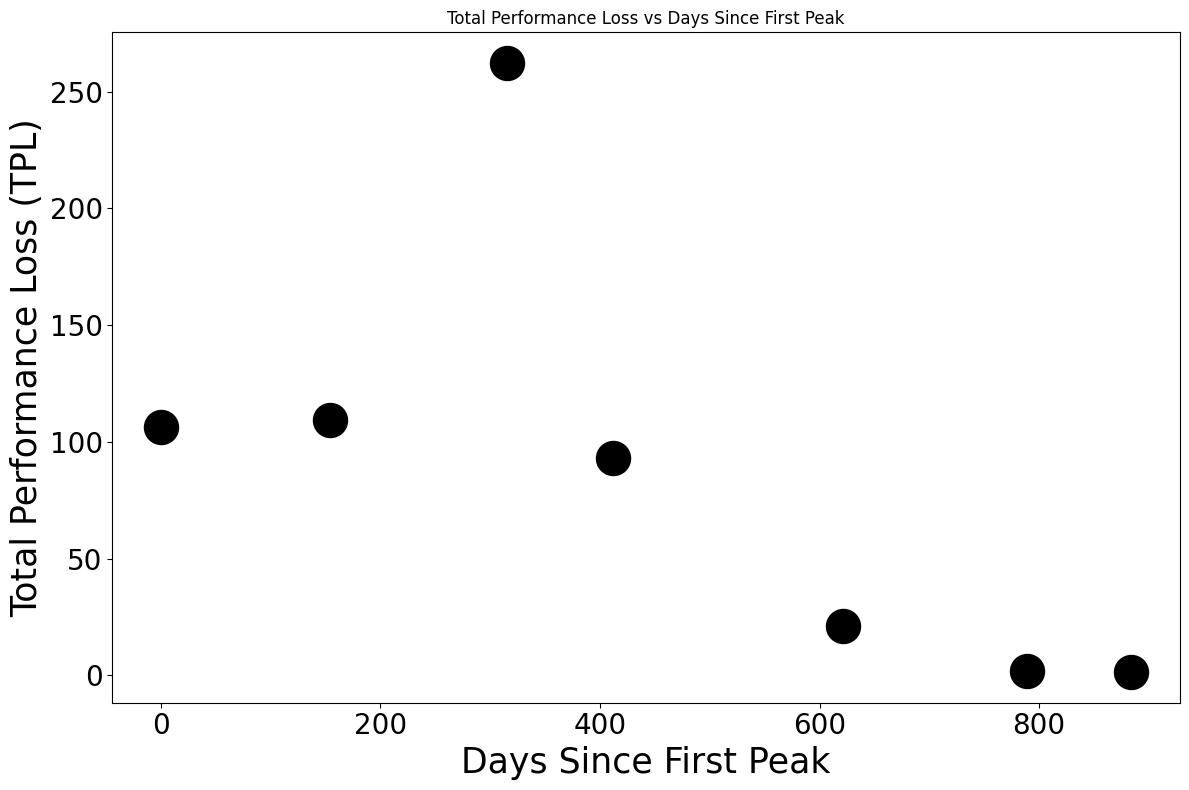

In [23]:
import numpy as np
from scipy.stats import skewnorm
from scipy.integrate import cumulative_trapezoid as cumtrapz

def compute_resilience_metrics_for_country(best_params, best_n):
    """Compute resilience metrics (TPL, MPL, DD, TtnD) for all waves of a single country."""
    # Validate input dimensions
    if len(best_params) < 4 * best_n:
        raise ValueError(f"Insufficient parameters: best_params has {len(best_params)} elements, but {4 * best_n} are required for {best_n} waves.")

    def skew_gaussian(x, mu, sigma, skew, scale):
        """Calculate skewed Gaussian curve."""
        return scale * skewnorm.pdf(x, skew, loc=mu, scale=sigma)

    def calculate_percentiles(x, wave, percent):
        """Calculate the time corresponding to a given percentile of the wave."""
        cumulative_area = cumtrapz(wave, x, initial=0)
        total_area = cumulative_area[-1]
        target_area = percent * total_area / 100
        percentile_index = np.searchsorted(cumulative_area, target_area)
        return x[min(percentile_index, len(x) - 1)]

    max_losses = []
    total_losses = []
    recovery_speeds = []
    time_to_next_wave = []
    peak_times = []  # Array to store peak times of each curve
    shifted_peak_times = []  # Store shifted peak times for each wave
    waves_data = []  # To include all data per wave for sorting and comparison

    # Calculate metrics for each wave
    for j in range(best_n):
        mu = best_params[4 * j]
        sigma = best_params[4 * j + 1]
        skew = best_params[4 * j + 2]
        scale = best_params[4 * j + 3]

        if sigma <= 0:
            continue

        x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 1000)
        wave = skew_gaussian(x, mu, sigma, skew, scale)

        # Calculate the maximum performance loss (height)
        max_loss = np.max(wave)
        max_losses.append(max_loss)
        wave_index = np.argmax(wave)
        # Store the peak time of the wave
        peak_time = x[wave_index]
        # Calculate shifted peak time so the first is 0, etc.
        if not peak_times:
            shifted_peak_time = 0
        else:
            shifted_peak_time = peak_time - peak_times[0]
        peak_times.append(peak_time)
        shifted_peak_times.append(shifted_peak_time)
        peak_times.append(peak_time)

        # Calculate the total performance loss (area under the wave)
        total_loss = np.trapz(wave, x)
        total_losses.append(total_loss)

        # Calculate recovery speed (time from 5th to 95th percentile)
        fifth_percentile_time = calculate_percentiles(x, wave, 5)
        ninety_fifth_percentile_time = calculate_percentiles(x, wave, 95)
        recovery_speed = ninety_fifth_percentile_time - fifth_percentile_time
        recovery_speeds.append(recovery_speed)

        # Collect data for sorting and Time to Next Wave calculation
        waves_data.append({
            'max_loss': max_loss,
            'total_loss': total_loss,
            'recovery_speed': recovery_speed,
            'fifth_percentile_time': fifth_percentile_time,
            'ninety_fifth_percentile_time': ninety_fifth_percentile_time,
            'peak_time': peak_time,
        })

    # Sort waves by their peak time
    waves_sorted = sorted(waves_data, key=lambda w: w['peak_time'])

    # Calculate Time to Next Wave based on peak times
    for i in range(len(waves_sorted) - 1):
        current_wave = waves_sorted[i]
        next_wave = waves_sorted[i + 1]
        time_to_next = next_wave['peak_time'] - current_wave['peak_time']
        time_to_next_wave.append(time_to_next)

    # Add NaN for the last wave (as no subsequent wave exists)
    # Return all calculated metrics
    return {
        'Max_Performance_Loss': [w['max_loss'] for w in waves_sorted],
        'Total_Performance_Loss': [w['total_loss'] for w in waves_sorted],
        'Recovery_Speed': [w['recovery_speed'] for w in waves_sorted],
        'Time_to_Next_Wave': time_to_next_wave,
        'Shifted_Peak_Times': [w['peak_time'] - waves_sorted[0]['peak_time'] for w in waves_sorted],
    }
    #     'Shifted_Peak_Times': shifted_peak_time,
    # }

# Example, where only the Total Performance Loss is plotted. From now on, like in the paper, this resilience metric is the only one considered.
resilience_metrics = compute_resilience_metrics_for_country(best_params, best_idx+2)
print("Resilience Metrics:", resilience_metrics)

def plot_tpl_vs_peak_time(resilience_metrics):
    """Scatterplot TPL (y-axis) vs Shifted Peak Times (x-axis)."""
    shifted_peak_time = resilience_metrics['Shifted_Peak_Times']
    tpl_values = resilience_metrics['Total_Performance_Loss']

    plt.figure(figsize=(12, 8))
    plt.scatter(shifted_peak_time, tpl_values, color='black', alpha=1, s=600)
    plt.title('Total Performance Loss vs Days Since First Peak')
    plt.xlabel('Days Since First Peak', fontsize=25)
    plt.ylabel('Total Performance Loss (TPL)', fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    # plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Example usage
plot_tpl_vs_peak_time(resilience_metrics)


C:\Users\fpvansteijn\AppData\Local\Temp\ipykernel_10920\973490233.py:16: RuntimeWarning: overflow encountered in exp
C:\Users\fpvansteijn\AppData\Local\Temp\ipykernel_10920\973490233.py:127: OptimizeWarning: Covariance of the parameters could not be estimated
C:\Users\fpvansteijn\AppData\Local\Temp\ipykernel_10920\973490233.py:15: RuntimeWarning: overflow encountered in exp
c:\Users\fpvansteijn\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_minpack_py.py:1024: RuntimeWarning: overflow encountered in square
C:\Users\fpvansteijn\AppData\Local\Temp\ipykernel_10920\973490233.py:10: RuntimeWarning: overflow encountered in exp
C:\Users\fpvansteijn\AppData\Local\Temp\ipykernel_10920\973490233.py:29: RuntimeWarning: overflow encountered in square
c:\Users\fpvansteijn\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_minpack_py.py:1062: RuntimeWarning: invalid value encountered in multiply


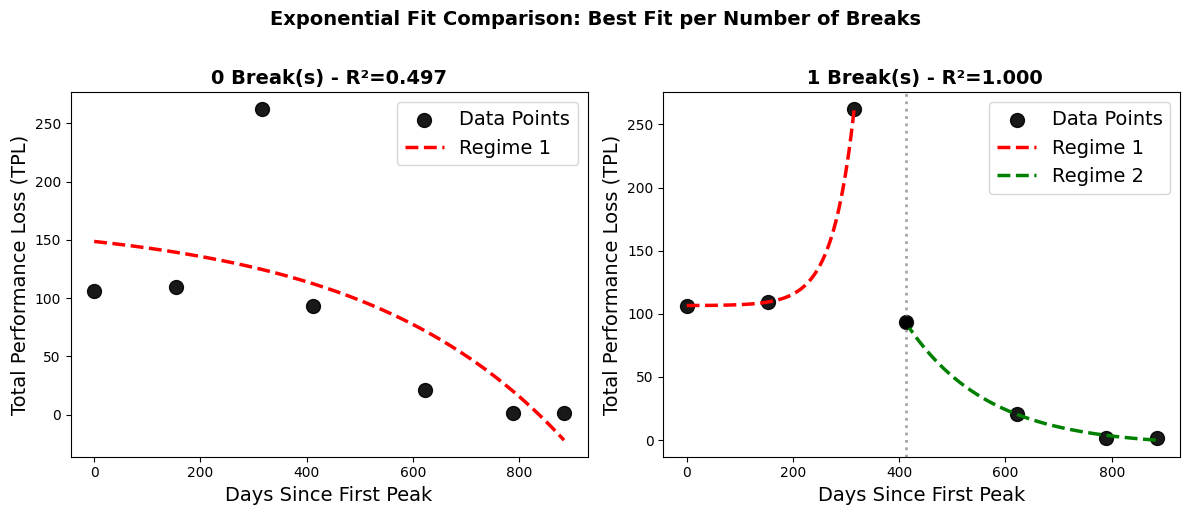

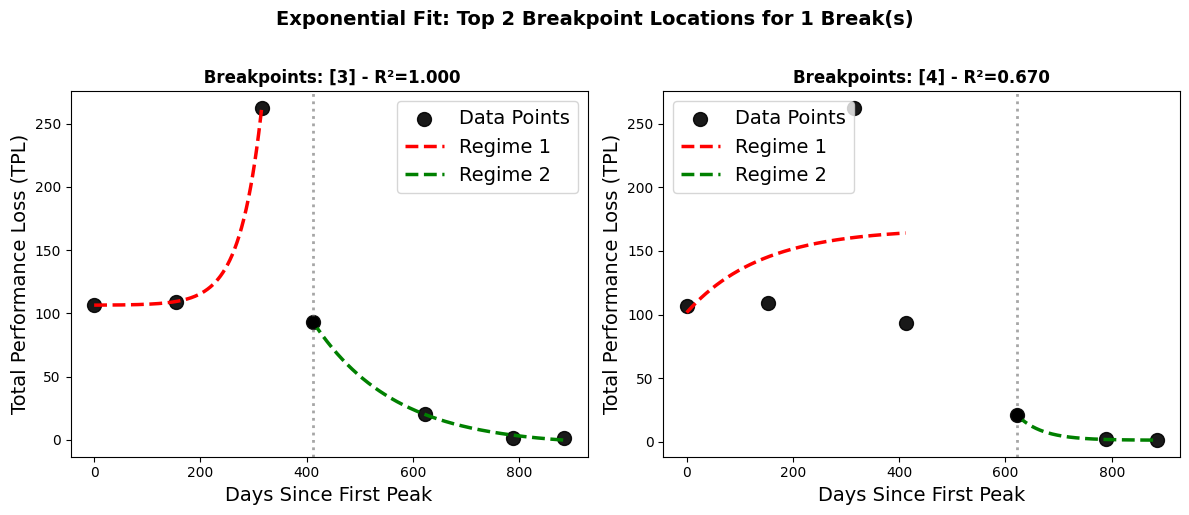

In [24]:
import numpy as np
from scipy.optimize import curve_fit
from itertools import combinations
import matplotlib.pyplot as plt



# Define a fitting function with a constant term
def exponential_fit(x, a, b, c):
    return a * np.exp(-b * x) + c

# Reparameterized model: enforce a + c >= 0 using exponential reparam
# S = a + c = exp(s) > 0  => c = exp(s) - a
def exponential_fit_reparam_exp(x, a, s, b):
    c = np.exp(s) - a
    return a * np.exp(-b * x) + c

# Helper to convert an (a,b,c) initial guess into reparam (a, s, b)
def ig_to_reparam(ig, eps=1e-12):
    a_ig, b_ig, c_ig = ig
    S = a_ig + c_ig
    if S <= 0:
        S = eps
    s_ig = np.log(S)
    return [a_ig, s_ig, b_ig]

# Calculate deviation as mean absolute error
def calculate_r2(y_values, fitted_curve):
    return 1 - np.sum((y_values - fitted_curve) ** 2) / np.sum((y_values - np.mean(y_values)) ** 2)

def fit_exponential(x, y):
    # Remove NaN values for fitting
    x = np.array(x)
    y = np.array(y, dtype=float)
    valid_mask = ~np.isnan(y)
    x = x[valid_mask]
    y = y[valid_mask]

    if len(x) < 2:
        print("Not enough data points to fit.")
        return None, None

    try:
        # Initial guess for parameters a, b, c
        initial_guess = [max(y) - min(y), 0.1, min(y)]
        params, covariance = curve_fit(exponential_fit, x, y, p0=initial_guess)
        fitted_curve = exponential_fit(x, *params)
        r2 = calculate_r2(y, fitted_curve)
        return params, r2
    except Exception as e:
        print(f"Error in fitting: {e}")
        return None, None

def fit_multiple_exponentials(x, y):
    x = np.array(x)
    y = np.array(y, dtype=float)
    valid_mask = ~np.isnan(y)
    x = x[valid_mask]
    y = y[valid_mask]
    n = len(x)
    if n < 3:
        return None, None, None

    # Logic: try all break-points
    max_breaks = min((n // 3) - 1, 2)
    
    # Dictionary to store all results
    all_results = {}  # Key: (num_breaks, breaks_tuple), Value: {params, r2, breaks, x_shifts}
    
    def fit_segment(x_seg, y_seg):
        x_shifted = x_seg - x_seg[0]
        if len(x_shifted) < 3:
            return None
        # Use a shared set of initial guesses for all segments
        initial_guesses = [
            [max(y_seg) - min(y_seg), 0.1, min(y_seg)],
            [-1, 0, 2 * min(y_seg)],
            [np.mean(y_seg), 0.01, np.min(y_seg)],
            [np.max(y_seg), 0.5, np.min(y_seg)],
            [1, 1, 0],
            [np.median(y_seg), 0.05, np.median(y_seg)],
            [np.std(y_seg), 0.2, np.mean(y_seg)],
            [max(y_seg), 0.01, min(y_seg)],
            [min(y_seg), 1, max(y_seg)],
            [np.ptp(y_seg), 0.001, np.mean(y_seg)],
            [0, 0.1, 0],
            [np.mean(y_seg), 1, np.min(y_seg)],
            # Extended guesses to avoid local optima
            [np.max(y_seg) * 2, 0.01, np.min(y_seg) / 2],
            [np.min(y_seg) * 2, 1, np.max(y_seg) / 2],
            [np.mean(y_seg) * 2, 0.5, np.median(y_seg) / 2],
            [np.std(y_seg) * 2, 0.05, np.mean(y_seg) * 2],
            [np.ptp(y_seg) * 2, 0.001, np.mean(y_seg) * 2],
            [np.max(y_seg), 1, np.min(y_seg)],
            [np.min(y_seg), 0.01, np.max(y_seg)],
            [np.median(y_seg), 1, np.mean(y_seg)],
            [np.mean(y_seg), 0.5, np.median(y_seg)],
            [np.max(y_seg), 0.001, np.min(y_seg)],
            [np.min(y_seg), 0.5, np.max(y_seg)],
            [np.ptp(y_seg), 1, np.mean(y_seg)],
            [np.std(y_seg), 1, np.median(y_seg)],
            # Increasing exponential guesses
            [np.max(y_seg), -0.01, np.min(y_seg)],
            [np.max(y_seg), -0.1, np.min(y_seg)],
            [np.max(y_seg), -1, np.min(y_seg)],
            [np.max(y_seg) * 2, -0.01, np.min(y_seg)],
            [np.max(y_seg) * 2, -0.1, np.min(y_seg)],
            [np.max(y_seg) * 2, -1, np.min(y_seg)],
            [np.mean(y_seg), -0.01, np.min(y_seg)],
            [np.mean(y_seg), -0.1, np.min(y_seg)],
            [np.mean(y_seg), -1, np.min(y_seg)],
            [np.ptp(y_seg), -0.01, np.min(y_seg)],
            [np.ptp(y_seg), -0.1, np.min(y_seg)],
            [np.ptp(y_seg), -1, np.min(y_seg)],
            [np.std(y_seg), -0.01, np.min(y_seg)],
            [np.std(y_seg), -0.1, np.min(y_seg)],
            [np.std(y_seg), -1, np.min(y_seg)],
        ]
        best_fit = None
        best_r2 = -np.inf

        # Convert initial guesses to reparameterized form
        initial_guesses_reparam = [ig_to_reparam(ig) for ig in initial_guesses]

        for initial_guess_reparam in initial_guesses_reparam:
            try:
                params_reparam, _ = curve_fit(exponential_fit_reparam_exp, x_shifted, y_seg, 
                                              p0=initial_guess_reparam)
                # Convert back to original (a, b, c)
                a_fit = params_reparam[0]
                s_fit = params_reparam[1]
                b_fit = params_reparam[2]
                c_fit = np.exp(s_fit) - a_fit

                params_orig = [a_fit, b_fit, c_fit]
                fitted_y = exponential_fit(x_shifted, *params_orig)
                r2 = calculate_r2(y_seg, fitted_y)
                if r2 > best_r2:
                    best_r2 = r2
                    best_fit = (params_orig, fitted_y, r2)
            except Exception:
                continue
        return best_fit

    # 0 breaks (single segment)
    fit = fit_segment(x, y)
    if fit:
        params, fitted_y, r2 = fit
        all_results[(0, ())] = {
            'params': [params],
            'r2': r2,
            'breaks': [],
            'x_shifts': [x[0]]
        }

    # 1 or 2 breaks
    for num_breaks in range(1, max_breaks + 1):
        possible_breaks = range(3, n - 2 * (max_breaks - num_breaks + 1) + 1)
        for breaks in combinations(possible_breaks, num_breaks):
            breaks = sorted(breaks)
            indices = [0] + list(breaks) + [n]
            seg_params = []
            fitted_curve = np.zeros_like(y)
            valid = True
            x_shifts = []
            
            for i in range(len(indices) - 1):
                start, end = indices[i], indices[i + 1]
                if end - start < 3:
                    valid = False
                    break
                x_seg = x[start:end]
                y_seg = y[start:end]
                x_shift = x_seg[0]
                fit = fit_segment(x_seg, y_seg)
                if not fit:
                    valid = False
                    break
                params, fitted_y, _ = fit
                seg_params.append(params)
                fitted_curve[start:end] = fitted_y
                x_shifts.append(x_shift)
            
            if valid:
                r2 = calculate_r2(y, fitted_curve)
                all_results[(num_breaks, tuple(breaks))] = {
                    'params': seg_params.copy(),
                    'r2': r2,
                    'breaks': list(breaks),
                    'x_shifts': x_shifts.copy()
                }

    # Find the best overall fit
    if not all_results:
        return None, None, None, None, None
    
    best_key = max(all_results.keys(), key=lambda k: all_results[k]['r2'])
    best_result = all_results[best_key]
    
    # Return: best_params, best_r2, best_breaks, best_x_shifts, all_results
    return (best_result['params'], 
            best_result['r2'], 
            best_result['breaks'], 
            best_result['x_shifts'],
            all_results)

# Extract TPL and Shifted Peak Times from resilience metrics
tpl_values = resilience_metrics['Total_Performance_Loss']
shifted_peak_times = resilience_metrics['Shifted_Peak_Times']

# Ensure the data is sorted by x (Shifted Peak Times) for fitting
sorted_indices = np.argsort(shifted_peak_times)
tpl_values = np.array(tpl_values)[sorted_indices]
shifted_peak_times = np.array(shifted_peak_times)[sorted_indices]

# Fit the exponential model
best_params, best_r2, best_breaks, best_x_shifts, all_results = fit_multiple_exponentials(shifted_peak_times, tpl_values)

# Extract TPL and Shifted Peak Times from resilience metrics
tpl_values = resilience_metrics['Total_Performance_Loss']
shifted_peak_times = resilience_metrics['Shifted_Peak_Times']

# Ensure the data is sorted by x (Shifted Peak Times) for fitting
sorted_indices = np.argsort(shifted_peak_times)
tpl_values = np.array(tpl_values)[sorted_indices]
shifted_peak_times = np.array(shifted_peak_times)[sorted_indices]

# Fit the exponential model
best_params, best_r2, best_breaks, best_x_shifts, all_results = fit_multiple_exponentials(shifted_peak_times, tpl_values)

# Group results by number of breaks
results_by_num_breaks = {}
for (num_breaks, breaks_tuple), result in all_results.items():
    if num_breaks not in results_by_num_breaks:
        results_by_num_breaks[num_breaks] = []
    results_by_num_breaks[num_breaks].append((breaks_tuple, result))

# Find the best number of breaks
best_num_breaks = max([k for k in results_by_num_breaks.keys()], 
                       key=lambda k: max([r['r2'] for _, r in results_by_num_breaks[k]]))

# Get best result for each number of breaks
best_results_per_num_breaks = {}
for num_breaks in sorted(results_by_num_breaks.keys()):
    best_for_breaks = max(results_by_num_breaks[num_breaks], 
                          key=lambda x: x[1]['r2'])
    best_results_per_num_breaks[num_breaks] = best_for_breaks

# Create subplots for: best fit per number of breaks (up to 3 plots)
num_subplots = len(best_results_per_num_breaks)
fig, axes = plt.subplots(1, num_subplots, figsize=(6 * num_subplots, 5))

# Handle single subplot case
if num_subplots == 1:
    axes = [axes]

# Plot 1: Best fit for each number of breaks
for idx, (num_breaks, (breaks_tuple, result)) in enumerate(sorted(best_results_per_num_breaks.items())):
    ax = axes[idx]
    
    # Plot data points
    ax.scatter(shifted_peak_times, tpl_values, color='black', alpha=0.9, s=100, label='Data Points')
    
    params_list = result['params']
    breaks_list = result['breaks']
    r2 = result['r2']
    
    # Plot each segment
    colors = ['red', 'green', 'orange']
    for i, params in enumerate(params_list):
        start = 0 if i == 0 else breaks_list[i - 1]
        end = len(shifted_peak_times) if i == len(params_list) - 1 else breaks_list[i]
        x_seg = shifted_peak_times[start:end]
        
        # Create smooth curve
        x_smooth = np.linspace(x_seg[0], x_seg[-1], 500)
        x_shifted = x_smooth - x_smooth[0]
        fitted_curve = exponential_fit(x_shifted, *params)
        
        # Plot smooth curve
        ax.plot(x_smooth, fitted_curve, color=colors[i], linewidth=2.5,
                label=f'Regime {i + 1}', linestyle='--')
        
        # Display parameters
        rounded_params = [round(p, 2) for p in params]
        # ax.text(x_smooth[len(x_smooth) // 2], max(fitted_curve),
        #         f'a={rounded_params[0]}\nb={rounded_params[1]}\nc={rounded_params[2]}',
        #         fontsize=9, color=colors[i], ha='center',
        #         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot breakpoints
    for bp_idx in breaks_list:
        bp_x = shifted_peak_times[bp_idx]
        bp_y = tpl_values[bp_idx]
        ax.axvline(bp_x, color='gray', linestyle=':', linewidth=2, alpha=0.7)
        ax.plot(bp_x, bp_y, 'ko', markersize=8)
    
    # Title with emphasis on best fit
    title_prefix = " " if num_breaks == best_num_breaks else ""
    ax.set_title(f'{title_prefix}{num_breaks} Break(s) - R²={r2:.3f}', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Days Since First Peak', fontsize=14)
    ax.set_ylabel('Total Performance Loss (TPL)', fontsize=14)
    # ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=14, loc='best')

plt.suptitle('Exponential Fit Comparison: Best Fit per Number of Breaks', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Plot 2: All breakpoint locations for the best number of breaks
if len(results_by_num_breaks[best_num_breaks]) > 1:
    best_for_num_breaks = results_by_num_breaks[best_num_breaks]
    
    # Get top 4 results for this number of breaks (or fewer if not available)
    sorted_results = sorted(best_for_num_breaks, key=lambda x: x[1]['r2'], reverse=True)
    num_to_plot = min(4, len(sorted_results))

    # Define the key for the best overall result for highlighting
    all_results_key_best = best_results_per_num_breaks[best_num_breaks][0]
    
    fig, axes = plt.subplots(1, num_to_plot, figsize=(6 * num_to_plot, 5))
    
    # Handle single subplot case
    if num_to_plot == 1:
        axes = [axes]
    
    for idx, (breaks_tuple, result) in enumerate(sorted_results[:num_to_plot]):
        ax = axes[idx]
        
        # Plot data points
        ax.scatter(shifted_peak_times, tpl_values, color='black', alpha=0.9, s=100, label='Data Points')
        
        params_list = result['params']
        breaks_list = result['breaks']
        r2 = result['r2']
        
        # Plot each segment
        colors = ['red', 'green', 'orange']
        for i, params in enumerate(params_list):
            start = 0 if i == 0 else breaks_list[i - 1]
            end = len(shifted_peak_times) if i == len(params_list) - 1 else breaks_list[i]
            x_seg = shifted_peak_times[start:end]
            
            # Create smooth curve
            x_smooth = np.linspace(x_seg[0], x_seg[-1], 500)
            x_shifted = x_smooth - x_smooth[0]
            fitted_curve = exponential_fit(x_shifted, *params)
            
            # Plot smooth curve
            ax.plot(x_smooth, fitted_curve, color=colors[i], linewidth=2.5,
                    label=f'Regime {i + 1}', linestyle='--')
            
            # Display parameters
            rounded_params = [round(p, 3) for p in params]
            # ax.text(x_smooth[len(x_smooth) // 2], max(fitted_curve),
            #         f'a={rounded_params[0]}\nb={rounded_params[1]}\nc={rounded_params[2]}',
            #         fontsize=9, color=colors[i], ha='center',
            #         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Plot breakpoints
        for bp_idx in breaks_list:
            bp_x = shifted_peak_times[bp_idx]
            bp_y = tpl_values[bp_idx]
            ax.axvline(bp_x, color='gray', linestyle=':', linewidth=2, alpha=0.7)
            ax.plot(bp_x, bp_y, 'ko', markersize=8)
        
        # Title with emphasis on best overall fit
        title_prefix = " " if (best_num_breaks, breaks_tuple) == (best_num_breaks, all_results_key_best) else ""
        ax.set_title(f'{title_prefix}Breakpoints: {breaks_list} - R²={r2:.3f}',
                     fontsize=12, fontweight='bold')
        ax.set_xlabel('Days Since First Peak', fontsize=14)
        ax.set_ylabel('Total Performance Loss (TPL)', fontsize=14)
        # ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(fontsize=14, loc='best')
    
    plt.suptitle(f'Exponential Fit: Top {num_to_plot} Breakpoint Locations for {best_num_breaks} Break(s)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
